In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense, Lambda, Layer, Conv2D, Conv2DTranspose, Flatten, Reshape, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import mean_squared_error, binary_crossentropy, kullback_leibler_divergence
from tensorflow.keras.callbacks import EarlyStopping, TerminateOnNaN, ReduceLROnPlateau
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, scipy
from sklearn.model_selection import train_test_split

from phenom_read_in_data import *
from fpr_tpr_calc import *

In [2]:
pd.set_option('display.max_columns', 100)

In [2]:
#Getthe data
df_bkg = single_csv_to_df('/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/background_chan1_7.79.csv')

In [3]:
df_bkg

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,...,obj13,E13,pt13,eta13,phi13,obj14,E14,pt14,eta14,phi14
0,7051621,z_jets,1,390017,0.538031,j,407492,393095,-0.266637,-2.68505,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33064349,njets,1,217448,0.663545,j,707690,390901,1.19577,-2.48665,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,179392659,njets,1,220238,-1.45891,j,484710,388499,0.669438,2.1595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,185746896,njets,1,237999,1.30691,j,913056,245434,-1.98767,0.978061,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84616096,njets,1,229855,-0.953545,j,302325,294936,0.181659,3.03634,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214180,134098620,njets,1,236904,0.294278,j,647782,316987,-1.33574,0.0408877,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214181,15237232,njets,1,263035,-2.15702,j,390920,325540,0.606702,0.269049,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214182,20494126,njets,1,344296,-1.45284,j,1.04316e+06,309613,-1.88456,1.17333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214183,85321109,njets,1,227666,0.495691,j,450608,309967,-0.89566,-2.33551,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
#If the number of max objects is prime, another column needs to be added to mitigate 

In [4]:
if ((len(df_bkg.columns)-5) % 2 != 0):
    num = str(int(((len(df_bkg.columns) - 5)/5) + 1))
    df_bkg['obj'+num]= -999
    df_bkg['E'+num] = -999
    df_bkg['pt'+num] = -999
    df_bkg['eta'+num] = -999
    df_bkg['phi'+num] = -999

In [7]:
df_bkg

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9,obj10,E10,pt10,eta10,phi10,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12,obj13,E13,pt13,eta13,phi13,obj14,E14,pt14,eta14,phi14
0,7051621,z_jets,1,390017,0.538031,j,407492,393095,-0.266637,-2.68505,j,633731,283693,1.4419,-0.451286,j,269569,145318,1.22541,2.36482,j,138520,110826,0.688498,2.66743,j,101435,87189.8,0.563578,-2.49198,j,183193,38577.6,-2.23818,-0.295831,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,33064349,njets,1,217448,0.663545,j,707690,390901,1.19577,-2.48665,j,165970,162374,-0.073124,0.558267,j,213806,88382.7,1.52776,0.769609,j,190327,63638.8,-1.75736,-1.3494,j,324303,56631.5,2.42978,3.03834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,179392659,njets,1,220238,-1.45891,j,484710,388499,0.669438,2.1595,j,466224,209644,1.43709,-1.48085,j,173345,159358,0.3921,0.722837,b,76508.9,63430.3,0.614221,-0.229462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,185746896,njets,1,237999,1.30691,j,913056,245434,-1.98767,0.978061,j,228497,202999,0.478876,-2.01883,j,153458,146721,-0.259158,-1.87386,j,126963,126389,0.0382953,-2.45528,j,50958.8,41187,0.653297,2.54775,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,84616096,njets,1,229855,-0.953545,j,302325,294936,0.181659,3.03634,j,360228,251837,-0.8903,0.173217,j,203074,200825,0.149532,2.22357,j,359058,56262.1,2.54026,-0.807584,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214180,134098620,njets,1,236904,0.294278,j,647782,316987,-1.33574,0.0408877,j,1.03028e+06,278691,1.98139,-2.63605,j,442513,190614,-1.48267,2.79699,j,353545,120815,1.73419,2.91943,j,34124.5,24021.7,0.867112,-2.37522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214181,15237232,njets,1,263035,-2.15702,j,390920,325540,0.606702,0.269049,j,1.83279e+06,265269,2.62055,2.28375,j,197980,103625,1.25981,-1.96533,j,191427,56799.1,-1.88419,-0.497967,j,54929.9,52948.5,0.25536,0.852269,j,76348.3,43636.1,1.14312,2.3847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214182,20494126,njets,1,344296,-1.45284,j,1.04316e+06,309613,-1.88456,1.17333,j,809841,304875,1.63051,2.00532,b,403629,196592,1.34505,-1.43694,j,400995,83865.8,-2.24571,-3.03264,j,285868,40030.8,-2.65281,-0.773111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
214183,85321109,njets,1,227666,0.495691,j,450608,309967,-0.89566,-2.33551,j,216603,214715,0.0388365,0.642919,b,122718,106325,-0.535995,-2.88472,j,132238,85920.4,0.990861,2.96581,j,87140.8,25784.8,1.88563,-0.1567

In [5]:
df = df_bkg.fillna(-999)
variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

In [6]:
#Now we one_hot encode the data to make sure we have a class definition
df = df[['process_ID']+variables]
one_hot = pd.get_dummies(df['process_ID'])
processes = one_hot.columns
df.drop('process_ID', axis = 'columns', inplace = True)
df = pd.concat([df, one_hot], sort = False, axis = 1)

In [7]:
E = [entry for entry in df.columns if entry[0] == 'E']
pt = [entry for entry in df.columns if entry[0:2] == 'pt']
eta = [entry for entry in df.columns if entry[0:2] == 'et']
phi = [entry for entry in df.columns if entry[0:2] == 'ph']

In [8]:
np_E = np.array(df[E])
np_pt = np.array(df[pt])
np_eta = np.array(df[eta])
np_phi = np.array(df[phi])

In [9]:
#We have created a df of our values and some kind of class label
#We should normalize
x = df[variables].values
x_scaled = StandardScaler().fit_transform(x)
df[variables] = x_scaled

x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
                                                    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

In [10]:
#Reshape the data. This will have to be done explicitly until you think of a clever way of doing it
x_train = x_train.reshape((x_train.shape[0], 1, -1, 4))
x_test = x_test.reshape((x_test.shape[0], 1, -1, 4))

In [11]:
#VAE Model
original_dim = x_train.shape[0]
input_shape = x_train.shape[1:]
latent_dim = 4
intermediate_dim = 50
kernel_max_norm = 1000.
act_fun = 'relu'
epsilon_std = 1.
filters = 32
kernel_size = (2, 2)
strides = (1, 1)
pool_size = (1, 1)

In [15]:
K.clear_session()

In [12]:
def sampling(args):
    z_mean, z_log_var=args
    epsilon=tf.random.uniform(shape=(K.shape(z_mean)[0], latent_dim))
    return z_mean+K.exp(z_log_var/2)*epsilon
    
#Define some losses
def kl_loss(y_true, y_pred):
    kl_loss = 1 + z_var - K.square(z_mean) - K.exp(z_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    #kl_loss = K.mean(kl_loss)
    return kl_loss

def recon_loss(y_true, y_pred):
    recon_loss = mean_squared_error(K.flatten(y_true), K.flatten(y_pred))
    recon_loss *= shape[0]*shape[1]*shape[2]
    #recon_loss = K.mean(recon_loss)
    return recon_loss
    
def my_vae_loss(y_true, y_pred):
    beta = 0.4
    recon = recon_loss(y_true, y_pred) 
    kl = kl_loss(y_true, y_pred)
    vae_loss = (1-beta)*recon + beta*kl
    return vae_loss

    
    #Layers
x_input = Input(shape = input_shape, name = 'Input')
conv_1 = Conv2D(filters = filters, 
                activation = act_fun,
                kernel_size = kernel_size,
                strides = strides, 
                padding = 'same', 
                name = 'conv_1')(x_input)
pool_1 = MaxPooling2D(pool_size = pool_size,
                          strides = 2, 
                          name = 'max_pool')(conv_1)
conv_2 = Conv2D(filters = filters, 
                activation = act_fun, 
                kernel_size = kernel_size, 
                strides = strides, 
                padding = 'same', 
                name = 'conv_2')(pool_1)
#Shape info needed to inform the dense layer in the decoder
flatten = Flatten()(conv_2)#(pool_1)
cnn = Model(x_input, flatten, name = 'cnn')
cnn.summary()

shape = input_shape
    
#Encoding
dense_encoder_1 = Dense(intermediate_dim,
                            activation = act_fun,
                            name = 'dense_encoder_1')(flatten)
dense_encoder_2 = Dense(16,
                            activation = act_fun,
                            name = 'dense_encoder_2')(dense_encoder_1)
z_mean = Dense(latent_dim, name = 'z_mean')(dense_encoder_2)
z_var = Dense(latent_dim, name = 'z_var')(dense_encoder_2)

z = Lambda(sampling, output_shape = (latent_dim, ), name = 'sampling')([z_mean, z_var])

encoder = Model(x_input, [z_mean, z_var, z], name = 'encoder')
encoder.summary()
    
#Decoding
dense_shape = shape[0]*shape[1]*shape[2]
decoder_input = Input(shape = (latent_dim, ), name = 'decoder_input')
dense_decoder_1 = Dense(dense_shape, 
                            activation = act_fun, 
                            name = 'dense_decoder_1')(decoder_input)
reshape = Reshape((shape[0], shape[1], shape[2]))(dense_decoder_1)

deconv_1 = Conv2DTranspose(filters = filters,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_1')(reshape)
deconv_2 = Conv2DTranspose(filters = 20,
                               kernel_size = kernel_size, 
                               activation = act_fun, 
                               strides = strides, 
                               padding = 'same', 
                               name = 'deconv_2')(deconv_1)

output = Conv2DTranspose(filters = 4, 
                             kernel_size = kernel_size, 
                             #activation = 'sigmoid', 
                             padding = 'same', 
                             strides = strides, 
                             name = 'decoder_output')(deconv_2)

decoder = Model(decoder_input, output, name = 'decoder')
decoder.summary()
    
#Build the VAE model
#outputs = decoder(encoder(x_input)[2])
#bvae = Model(x_input, outputs, name = 'vae')
    
#bvae.compile(optimizer = 'rmsprop', loss = my_vae_loss, metrics = [kl_loss, recon_loss])
#bvae.summary()

Model: "cnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 1, 14, 4)]        0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 1, 14, 32)         544       
_________________________________________________________________
max_pool (MaxPooling2D)      (None, 1, 7, 32)          0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 1, 7, 32)          4128      
_________________________________________________________________
flatten (Flatten)            (None, 224)               0         
Total params: 4,672
Trainable params: 4,672
Non-trainable params: 0
_________________________________________________________________
Model: "encoder"
__________________________________________________________________________________________________
Layer (type

In [15]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class bVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(bVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]

        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.mse(data, reconstruction)
            )
            reconstruction_loss *= 14*4
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            beta = 0.4
            total_loss = (1-beta)*reconstruction_loss + beta*kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }
    
    #def call(self, inputs, **kwargs):
    #    return self.model(inputs, decoder)

In [16]:
#Build the VAE model
#outputs = decoder(encoder(x_input)[2])
bvae = bVAE(encoder, decoder)
bvae.compile(optimizer = 'rmsprop')#, loss = my_vae_loss, metrics = [kl_loss, recon_loss])

In [21]:
x_val = x_train[:int(len(x_train)/3.)]
x_train = x_train[int(len(x_train)/3.):]

In [22]:
epochs = 100
batch_size = 1000
history_val = bvae.fit(x = x_val, epochs = epochs, batch_size = batch_size, verbose = 0)

history_train = bvae.fit(x = x_train, epochs = epochs, batch_size = batch_size, verbose = 2)

Epoch 1/100
129/129 - 4s - loss: 7.9908 - reconstruction_loss: 12.4572 - kl_loss: 1.2911
Epoch 2/100
129/129 - 5s - loss: 8.3830 - reconstruction_loss: 13.1173 - kl_loss: 1.2816
Epoch 3/100
129/129 - 4s - loss: 8.4647 - reconstruction_loss: 13.2606 - kl_loss: 1.2707
Epoch 4/100
129/129 - 4s - loss: 8.4127 - reconstruction_loss: 13.1170 - kl_loss: 1.3562
Epoch 5/100
129/129 - 5s - loss: 8.3617 - reconstruction_loss: 13.0607 - kl_loss: 1.3132
Epoch 6/100
129/129 - 4s - loss: 486.0249 - reconstruction_loss: 807.4944 - kl_loss: 3.8206
Epoch 7/100
129/129 - 4s - loss: 8.3289 - reconstruction_loss: 13.0424 - kl_loss: 1.2586
Epoch 8/100
129/129 - 4s - loss: 8.6714 - reconstruction_loss: 13.5224 - kl_loss: 1.3948
Epoch 9/100
129/129 - 6s - loss: 7.9139 - reconstruction_loss: 12.3572 - kl_loss: 1.2490
Epoch 10/100
129/129 - 5s - loss: 8.4486 - reconstruction_loss: 13.2264 - kl_loss: 1.2819
Epoch 11/100
129/129 - 5s - loss: 8.0618 - reconstruction_loss: 12.6269 - kl_loss: 1.2141
Epoch 12/100
129

Epoch 92/100
129/129 - 4s - loss: 8.3959 - reconstruction_loss: 12.7137 - kl_loss: 1.9194
Epoch 93/100
129/129 - 4s - loss: 7.4858 - reconstruction_loss: 11.6390 - kl_loss: 1.2559
Epoch 94/100
129/129 - 4s - loss: 7.7304 - reconstruction_loss: 12.0294 - kl_loss: 1.2819
Epoch 95/100
129/129 - 4s - loss: 7.5019 - reconstruction_loss: 11.6330 - kl_loss: 1.3054
Epoch 96/100
129/129 - 4s - loss: 7.7927 - reconstruction_loss: 12.0903 - kl_loss: 1.3463
Epoch 97/100
129/129 - 4s - loss: 7.7945 - reconstruction_loss: 12.1414 - kl_loss: 1.2742
Epoch 98/100
129/129 - 4s - loss: 7.6357 - reconstruction_loss: 11.8206 - kl_loss: 1.3583
Epoch 99/100
129/129 - 4s - loss: 7.3317 - reconstruction_loss: 11.3604 - kl_loss: 1.2887
Epoch 100/100
129/129 - 4s - loss: 7.7853 - reconstruction_loss: 12.0349 - kl_loss: 1.4108


In [23]:
_, _, z = encoder.predict(x_test.reshape(x_test.shape[0], 1, -1, 4))
y_pred = decoder.predict(z)

In [24]:
x_test_reshape = x_test.reshape(x_test.shape[0], -1)

In [25]:
x_test_df = pd.DataFrame(x_test_reshape, columns = variables)

In [26]:
x_test_E = np.array(x_test_df[E])
x_test_pt = np.array(x_test_df[pt])
x_test_phi = np.array(x_test_df[phi])
x_test_eta = np.array(x_test_df[eta])

In [27]:
y_pred_reshape = y_pred.reshape(y_pred.shape[0], -1)

In [28]:
y_pred_df = pd.DataFrame(y_pred_reshape, columns = variables)

In [29]:
y_pred_E = np.array(y_pred_df[E])
y_pred_pt = np.array(y_pred_df[pt])
y_pred_phi = np.array(y_pred_df[phi])
y_pred_eta = np.array(y_pred_df[eta])

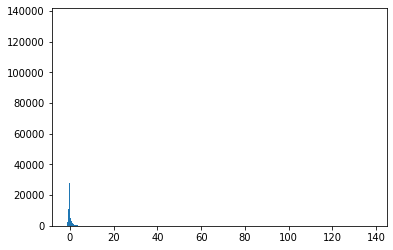

In [30]:
n, bins, patches = plt.hist(x_test_E.flatten(), 1000)

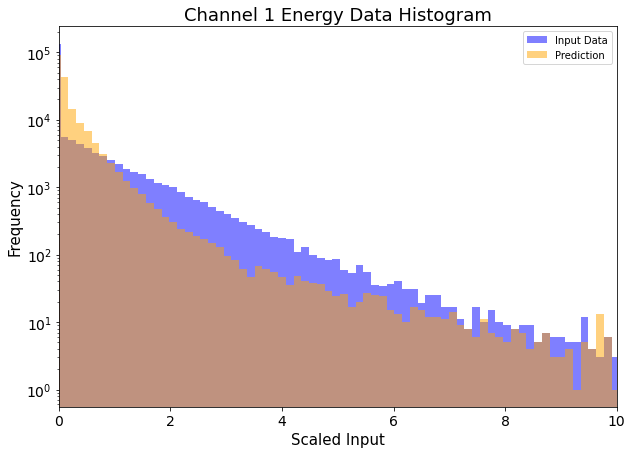

In [31]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Channel 1 Energy Data Histogram', fontsize = 18)
plt.hist(x_test_E.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_E.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

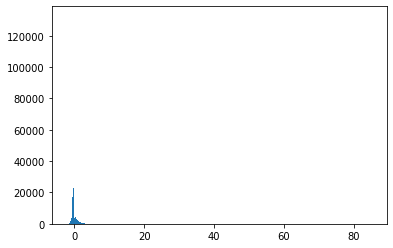

In [32]:
n, bins, patches = plt.hist(x_test_pt.flatten(), 1000)

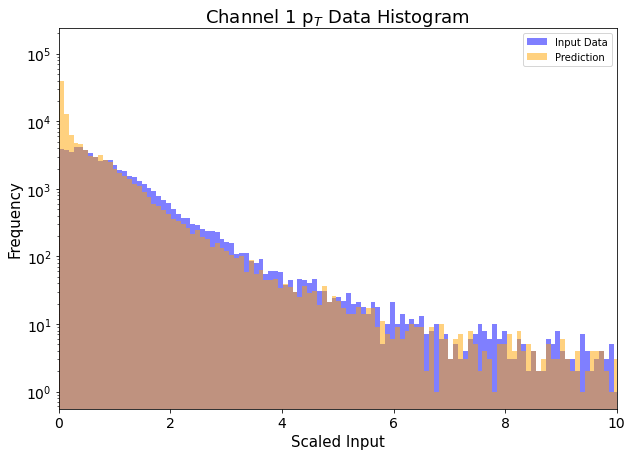

In [33]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 1 p$_T$ Data Histogram', fontsize = 18)
plt.hist(x_test_pt.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_pt.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

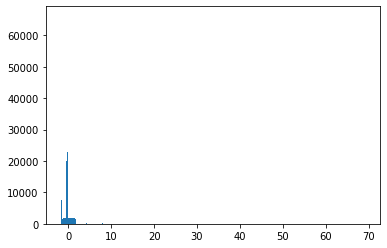

In [35]:
n, bins, patches = plt.hist(x_test_phi.flatten(), 1000)

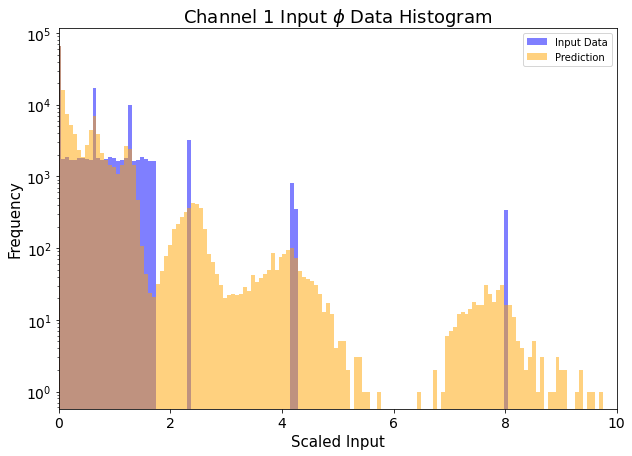

In [36]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 1 Input $\phi$ Data Histogram', fontsize = 18)
plt.hist(x_test_phi.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_phi.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

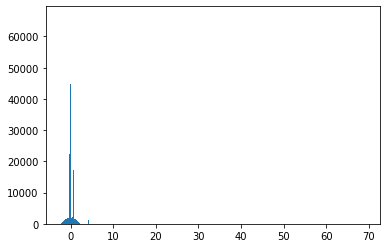

In [37]:
n, bins, patches = plt.hist(x_test_eta.flatten(), 1000)

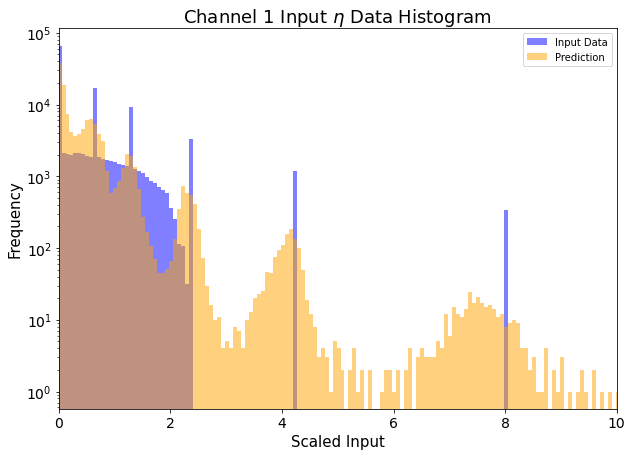

In [38]:
plt.figure(figsize=(10,7))
plt.xlim(0, 10)
plt.xlabel('Scaled Input', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.title('Channel 1 Input $\eta$ Data Histogram', fontsize = 18)
plt.hist(x_test_eta.flatten(), bins = bins, color='blue', log=True, label='Input Data', alpha=0.5)
plt.hist(y_pred_eta.flatten(), bins = bins, color='orange', log=True, label='Prediction', alpha=0.5)
plt.legend()
plt.show()

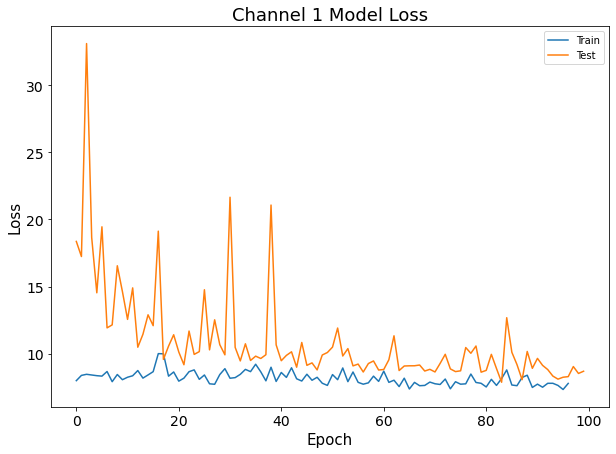

In [39]:
loss = [x for x in history_train.history['loss'] if x<100]
val_loss = [x for x in history_val.history['loss'] if x<100]
plt.figure(figsize = (10,7))
plt.plot(loss)
plt.plot(val_loss)
plt.title('Channel 1 Model Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc='upper left')
plt.show()

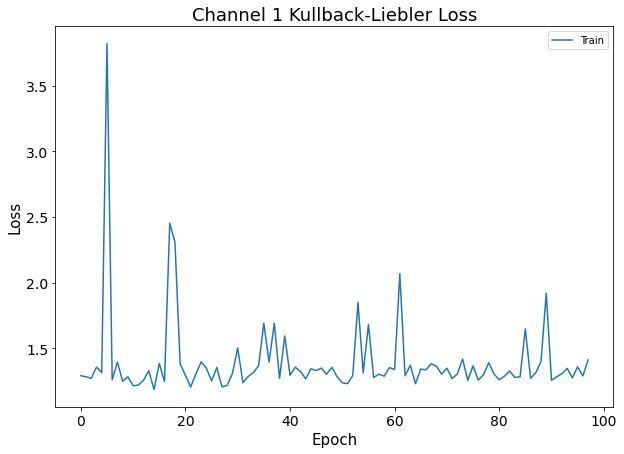

In [40]:
kl_loss = [x for x in history_train.history['kl_loss'] if x<10]
plt.figure(figsize = (10, 7))
plt.plot(kl_loss)
plt.title('Channel 1 Kullback-Liebler Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc = 'upper left')
plt.show()

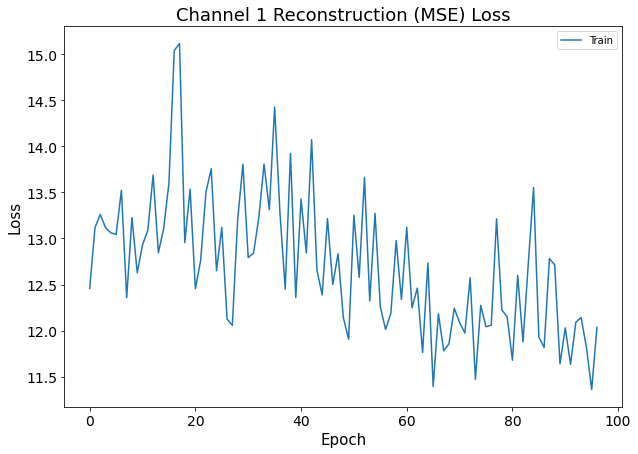

In [41]:
recon_loss = [x for x in history_train.history['reconstruction_loss'] if x<100]
plt.figure(figsize = (10, 7))
plt.plot(recon_loss)
plt.title('Channel 1 Reconstruction (MSE) Loss', fontsize = 18)
plt.ylabel('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(['Train', 'Test'])#, loc = 'upper left')
plt.show()

In [37]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

In [38]:
#We are going to try plotting our roc curve. First we should get a set of loss values and make our binary vecs

In [39]:
df_glu_1400 = single_csv_to_df('/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/glgl1400_neutralino1100_chan1.csv')
df_glu_1400

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9,obj10,E10,pt10,eta10,phi10,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12,obj13,E13,pt13,eta13,phi13
0,90934,glgl1400_neutralino1100,8.17901e-07,966678,1.88616,j,1.11905e+06,1.09924e+06,0.150071,-1.34083,j,559871,165567,-1.88859,1.47369,j,226151,165330,-0.802848,2.94516,j,197519,154998,-0.720248,-0.0941964,j,133609,71234.1,1.23674,-0.667677,j,33148.6,24613.8,-0.795032,2.00452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,90934,glgl1400_neutralino1100,8.17901e-07,272431,-0.253703,j,275612,245021,-0.469702,-2.83812,j,166684,143305,0.531173,2.26821,j,205771,103965,-1.30103,-0.295798,j,129144,81242.1,1.02916,0.971936,j,302875,75746.9,2.06247,2.73778,j,131327,67613.4,-1.2765,-1.23786,j,1.82257e+06,38105.4,-4.56068,2.93394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,90934,glgl1400_neutralino1100,8.17901e-07,326833,0.49523,j,563988,312717,1.18657,-1.43681,j,1.34499e+06,250037,-2.36676,2.86416,j,184328,133523,-0.826793,1.13601,j,96540.3,95206.5,-0.0201483,-2.08715,j,168074,91527.5,-1.21047,2.77205,j,57918.2,53202.6,-0.414333,2.65978,j,77619,40325.2,1.26557,-0.140817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,90934,glgl1400_neutralino1100,8.17901e-07,393198,0.551451,b,364748,274872,-0.761967,2.96886,j,636767,256438,1.55925,-2.528,b,186686,129489,0.906826,-0.737084,j,240253,63869.8,1.99805,0.277679,j,48670.2,24901.7,-1.28639,-2.24453,j,26835.1,24075.5,0.45788,-1.43184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,90934,glgl1400_neutralino1100,8.17901e-07,264860,0.141786,j,359307,342962,0.222528,-2.76879,j,1.03187e+06,201249,2.31779,0.180633,j,133718,103956,-0.715326,2.11942,j,90369.9,72605,-0.676961,-2.51046,j,29353.3,28919.1,0.127996,2.61299,j,27749.1,26424.4,-0.288125,-1.97123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,90934,glgl1400_neutralino1100,8.17901e-07,358586,-2.68716,j,544458,319749,-1.11093,0.350326,j,141426,133030,-0.339183,0.288143,j,131650,128141,-0.211974,3.04308,j,101701,51492.9,1.29381,0.116708,j,819695,47059.3,-3.54982,-1.41129,j,76579.2,29094.8,-1.62119,2.88376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4092,90934,glgl1400_neutralino1100,8.17901e-07,465893,-3.08648,j,304548,296864,0.179741,-0.647328,j,181607,170330,-0.361503,0.820824,j,131605,126303,0.215301,0.0479811,j,149316,69157.4,1.40403,1.9427,j,67379.9,43891.9,0.982377,0.697756,j,36061.3,28766.5,0.696602,-2.50107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4093,90934,glgl1400_neutralino1100,8.17901e-07,785737,-2.1627,j,694694,623764,-0.408878,1.48107,j,451083,415452,0.380902,0.699667,j,387672,255939,-0.970173,-0.776873,j,163110,147494,-0.399345,2.53661,j,254535,102326,-1.5605,-2.45995,j,86432.7,84916.4,-0.111943,0.0639032,j,71494.7,67961.2,0.288945,-1.56212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4094,90934,glgl1400_neutralin

In [40]:
if (len(df_glu_1400)-5)%2 != 0: 
    num = str(int(((len(df_glu_1400.columns) - 5)/5) + 1))
    df_glu_1400['obj'+num]= -999
    df_glu_1400['E'+num] = -999
    df_glu_1400['pt'+num] = -999
    df_glu_1400['eta'+num] = -999
    df_glu_1400['phi'+num] = -999

In [41]:
df_glu_1400

,event_ID,process_ID,event_weight,MET,MET_Phi,obj1,E1,pt1,eta1,phi1,obj2,E2,pt2,eta2,phi2,obj3,E3,pt3,eta3,phi3,obj4,E4,pt4,eta4,phi4,obj5,E5,pt5,eta5,phi5,obj6,E6,pt6,eta6,phi6,obj7,E7,pt7,eta7,phi7,obj8,E8,pt8,eta8,phi8,obj9,E9,pt9,eta9,phi9,obj10,E10,pt10,eta10,phi10,obj11,E11,pt11,eta11,phi11,obj12,E12,pt12,eta12,phi12,obj13,E13,pt13,eta13,phi13,obj14,E14,pt14,eta14,phi14
0,90934,glgl1400_neutralino1100,8.17901e-07,966678,1.88616,j,1.11905e+06,1.09924e+06,0.150071,-1.34083,j,559871,165567,-1.88859,1.47369,j,226151,165330,-0.802848,2.94516,j,197519,154998,-0.720248,-0.0941964,j,133609,71234.1,1.23674,-0.667677,j,33148.6,24613.8,-0.795032,2.00452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
1,90934,glgl1400_neutralino1100,8.17901e-07,272431,-0.253703,j,275612,245021,-0.469702,-2.83812,j,166684,143305,0.531173,2.26821,j,205771,103965,-1.30103,-0.295798,j,129144,81242.1,1.02916,0.971936,j,302875,75746.9,2.06247,2.73778,j,131327,67613.4,-1.2765,-1.23786,j,1.82257e+06,38105.4,-4.56068,2.93394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
2,90934,glgl1400_neutralino1100,8.17901e-07,326833,0.49523,j,563988,312717,1.18657,-1.43681,j,1.34499e+06,250037,-2.36676,2.86416,j,184328,133523,-0.826793,1.13601,j,96540.3,95206.5,-0.0201483,-2.08715,j,168074,91527.5,-1.21047,2.77205,j,57918.2,53202.6,-0.414333,2.65978,j,77619,40325.2,1.26557,-0.140817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
3,90934,glgl1400_neutralino1100,8.17901e-07,393198,0.551451,b,364748,274872,-0.761967,2.96886,j,636767,256438,1.55925,-2.528,b,186686,129489,0.906826,-0.737084,j,240253,63869.8,1.99805,0.277679,j,48670.2,24901.7,-1.28639,-2.24453,j,26835.1,24075.5,0.45788,-1.43184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
4,90934,glgl1400_neutralino1100,8.17901e-07,264860,0.141786,j,359307,342962,0.222528,-2.76879,j,1.03187e+06,201249,2.31779,0.180633,j,133718,103956,-0.715326,2.11942,j,90369.9,72605,-0.676961,-2.51046,j,29353.3,28919.1,0.127996,2.61299,j,27749.1,26424.4,-0.288125,-1.97123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,90934,glgl1400_neutralino1100,8.17901e-07,358586,-2.68716,j,544458,319749,-1.11093,0.350326,j,141426,133030,-0.339183,0.288143,j,131650,128141,-0.211974,3.04308,j,101701,51492.9,1.29381,0.116708,j,819695,47059.3,-3.54982,-1.41129,j,76579.2,29094.8,-1.62119,2.88376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
4092,90934,glgl1400_neutralino1100,8.17901e-07,465893,-3.08648,j,304548,296864,0.179741,-0.647328,j,181607,170330,-0.361503,0.820824,j,131605,126303,0.215301,0.0479811,j,149316,69157.4,1.40403,1.9427,j,67379.9,43891.9,0.982377,0.697756,j,36061.3,28766.5,0.696602,-2.50107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-999,-999,-999,-999,-999
4093,90934,glgl1400_neutralino1100,8.17901e-07,785737,-2.1627,j,694694,623764,-0.408878,1.48107,j,451083,415452,0.380902,0.699667,j,387672,255939,-0.970173,-0.776873,j,163110,147494,-0.399345,2.53661,j,254535,102326,-1.5605,-2.45995,j

In [42]:
df_glu_1400 = df_glu_1400.fillna(-999)
variables = [entry for entry in df_glu_1400.columns if entry[0] == 'E'] + [entry for entry in df_glu_1400.columns if entry[0:2] == 'pt'] + [entry for entry in df_glu_1400.columns if entry[0:2] == 'et'] + [entry for entry in df_glu_1400.columns if entry[0:2] == 'ph']

In [43]:
df_glu_1400 = df_glu_1400[['process_ID']+variables]
one_hot = pd.get_dummies(df_glu_1400['process_ID'])
processes = one_hot.columns
df_glu_1400.drop('process_ID', axis = 'columns', inplace = True)
df_glu_1400 = pd.concat([df_glu_1400, one_hot], sort = False, axis = 1)

In [44]:
E = [entry for entry in df_glu_1400.columns if entry[0] == 'E']
pt = [entry for entry in df_glu_1400.columns if entry[0:2] == 'pt']
eta = [entry for entry in df_glu_1400.columns if entry[0:2] == 'et']
phi = [entry for entry in df_glu_1400.columns if entry[0:2] == 'ph']

In [45]:
x_glu_1400 = df_glu_1400[variables].values
x_glu_1400_scaled = StandardScaler().fit_transform(x_glu_1400)
df_glu_1400[variables] = x_glu_1400_scaled

x_train_glu_1400, x_test_glu_1400, y_train_glu_1400, y_test_glu_1400 = train_test_split(df_glu_1400[variables].values,
                                                                                        df_glu_1400[processes].values, 
                                                                                        shuffle = True,
                                                                                        random_state = 42,
                                                                                        test_size = 0.1)

In [46]:
x_train_glu_1400 = x_train_glu_1400.reshape((x_train_glu_1400.shape[0], 1, -1, 4))
x_test_glu_1400 = x_test_glu_1400.reshape((x_test_glu_1400.shape[0], 1, -1, 4))

In [47]:
y_pred_sm = [bvae.predict(x_test.reshape(x_test.shape[0], 1, 1, -1, 4)[i]) for i in range(x_test.shape[0])]

In [48]:
y_pred_bsm = [bvae.predict(x_test_glu_1400.reshape(x_test_glu_1400.shape[0], 1, 1, -1, 4)[i]) for i in range(x_test_glu_1400.shape[0])]

In [49]:
y_pred_total = np.append(y_pred_sm, y_pred_bsm)

In [50]:
y_pred_sm = np.array(y_pred_sm)
y_pred_bsm = np.array(y_pred_bsm)
x_test_flatten = np.array(x_test)
x_test_glu_1400_flatten = np.array(x_test_glu_1400)

In [51]:
y_pred_sm = y_pred_sm.flatten()
y_pred_bsm = y_pred_bsm.flatten()
x_test_flatten = x_test_flatten.flatten()
x_test_glu_1400_flatten = x_test_glu_1400_flatten.flatten()

In [52]:
y_true = np.append(np.zeros(len(y_pred_sm)), np.ones(len(y_pred_bsm)))

In [53]:
y_pred_total_norm = y_pred_total/np.linalg.norm(y_pred_total)

In [54]:
from fpr_tpr_calc import *

In [55]:
fpr, tpr, _ = roc_curve(y_true, y_pred_total_norm)
roc_auc = auc(fpr, tpr)

In [45]:
path1 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/glgl1400_neutralino1100_chan1.csv'

#fpr1, tpr1 = fpr_tpr_calc(path1, bvae, x_test, df_bkg)

In [46]:
path2 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/glgl1600_neutralino800_chan1.csv'
path3 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/stlp_st1000_chan1.csv'
path4 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/monotop_200_A_chan1.csv'
path5 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/stop2b1000_neutralino300_chan1.csv'
path6 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/sqsq_sq1800_neut800_chan1.csv'
path7 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/sqsq1_sq1400_neut800_chan1.csv'
path8 = '/home/joe/Documents/Work/PhD/dark_machines/training_files/chan1/signals/monojet_Zp2000.0_DM_50.0_chan1.csv'

In [47]:
paths = [path1, path2, path3, path4, path5, path6, path7, path8]

fpr2, tpr2 = fpr_tpr_calc(path2, bvae, x_test, df_bkg)
fpr3, tpr3 = fpr_tpr_calc(path3, bvae, x_test, df_bkg)
fpr4, tpr4 = fpr_tpr_calc(path4, bvae, x_test, df_bkg)
fpr5, tpr5 = fpr_tpr_calc(path5, bvae, x_test, df_bkg)
fpr6, tpr6 = fpr_tpr_calc(path6, bvae, x_test, df_bkg)
fpr7, tpr7 = fpr_tpr_calc(path7, bvae, x_test, df_bkg)
fpr8, tpr8 = fpr_tpr_calc(path8, bvae, x_test, df_bkg)

In [48]:
fprs = []
tprs = []
for path in paths:
    df = single_csv_to_df(path)
    if (len(df)-5)%2 != 0:
        num = str(int(((len(df.columns) - 5)/5) + 1))
        df['obj'+num]= -999
        df['E'+num] = -999
        df['pt'+num] = -999
        df['eta'+num] = -999
        df['phi'+num] = -999

    if (len(df.columns)< len(df_bkg.columns)):
        diff = int(((len(df_bkg.columns)-5)/5))-int(((len(df.columns)-5)/5))
        num = int(((len(df.columns) - 5)/5) + 1)
        for i in range(diff):
            df['obj'+str(num)]= -999
            df['E'+str(num)] = -999
            df['pt'+str(num)] = -999
            df['eta'+str(num)] = -999
            df['phi'+str(num)] = -999
            num+=1
    df = df.fillna(-999)
    variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

    df = df[['process_ID']+variables]
    one_hot = pd.get_dummies(df['process_ID'])
    processes = one_hot.columns
    df.drop('process_ID', axis = 'columns', inplace = True)
    df = pd.concat([df, one_hot], sort = False, axis = 1)


    x = df[variables].values
    x_scaled = StandardScaler().fit_transform(x)
    df[variables] = x_scaled

    _, x_test_bsm, _, y_test_bsm = train_test_split(df[variables].values,
                                                    df[processes].values, 
                                                    shuffle = True,
                                                    random_state = 42,
                                                    test_size = 0.1)

    #x_train = x_train.reshape((x_train.shape[0], 1, -1, 4))
    x_test_bsm = x_test_bsm.reshape((x_test_bsm.shape[0], 1, -1, 4))
    _, _, z_bsm = encoder.predict(x_test_bsm.reshape(x_test_bsm.shape[0], 1, -1, 4))
    y_bsm = decoder.predict(z_bsm)
    _, _, z = encoder.predict(x_test.reshape(x_test.shape[0], 1, -1, 4))
    y_sm = decoder.predict(z)
    y_total = np.append(y_sm, y_bsm)
    y_sm = y_sm.flatten()
    y_bsm = y_bsm.flatten()
    
    
    y_true = np.append(np.zeros(len(y_sm)), np.ones(len(y_bsm)))
    y_total_norm = y_total/np.linalg.norm(y_total)
    
    fpr, tpr, _ = roc_curve(y_true, y_total_norm)
    fprs.append(fpr)
    tprs.append(tpr)

In [49]:
colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'lime']

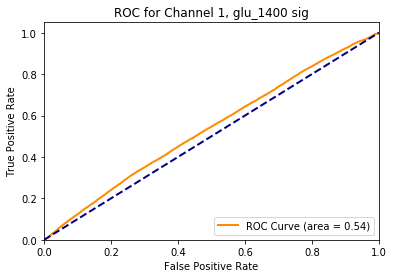

In [61]:
roc_auc = auc(fpr, tpr)
lw = 2
plt.plot(fpr, tpr, color = 'darkorange', lw = lw, 
         label = 'ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0,1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0., 1.])
plt.ylim([0., 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Channel 1, glu_1400 sig')
plt.legend(loc = 'lower right')
plt.show()

In [51]:
#fprs = [fpr1, fpr2, fpr3, fpr4, fpr5, fpr6, fpr7, fpr8]
#tprs = [tpr1, tpr2, tpr3, tpr4, tpr5, tpr6, tpr7, tpr8]
signals = ['glgl1400_neutralino1100', 
           'glgl1600_neutralino800', 
           'stlp_st1000',
           'monotop_200',
           'stop2b1000', 
           'sqsq_sq1800_neut800', 
           'sqsq1_sq1400', 
           'monojet_Zp2000.0_DM_50.0']

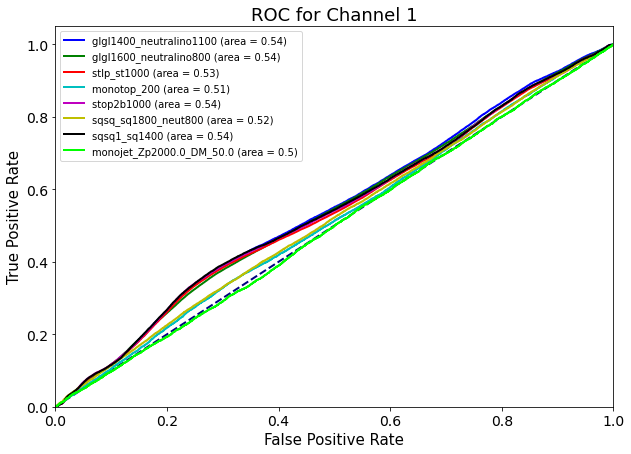

In [52]:
lw = 2
plt.figure(figsize = (10, 7))
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0., 1.])
plt.ylim([0, 1.05])
plt.title('ROC for Channel 1', fontsize = 18)
for fpr, tpr, sig, col in zip(fprs, tprs, signals, colours):
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color = col, lw = lw, 
             label = '{} (area = {})'.format(sig, round(roc_auc, 2)))
plt.legend()
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.show()

In [64]:
from performance import *

In [65]:
y_pred = y_pred.flatten()

In [66]:
AUC = []
epsilon1 = []
epsilon2 = []
epsilon3 = []

In [67]:
for i in paths:
    df_sig = single_csv_to_df(path1)
    if ((len(df_sig.columns)-5) % 2 != 0):
        num = str(int(((len(df_sig.columns) - 5)/5) + 1))
        df_sig['obj'+num]= -999
        df_sig['E'+num] = -999
        df_sig['pt'+num] = -999
        df_sig['eta'+num] = -999
        df_sig['phi'+num] = -999
    
    df = df_sig.fillna(-999)
    variables = [entry for entry in df.columns if entry[0] == 'E'] + [entry for entry in df.columns if entry[0:2] == 'pt'] + [entry for entry in df.columns if entry[0:2] == 'et'] + [entry for entry in df.columns if entry[0:2] == 'ph']

    #Now we one_hot encode the data to make sure we have a class definition
    df = df[['process_ID']+variables]
    one_hot = pd.get_dummies(df['process_ID'])
    processes = one_hot.columns
    df.drop('process_ID', axis = 'columns', inplace = True)
    df = pd.concat([df, one_hot], sort = False, axis = 1)

    x = df[variables].values
    x_scaled = StandardScaler().fit_transform(x)
    df[variables] = x_scaled

    x_train, x_test, y_train, y_test = train_test_split(df[variables].values,
                                                        df[processes].values, 
                                                        shuffle = True,
                                                        random_state = 42,
                                                        test_size = 0.1)
    x_test = x_test.reshape((x_test.shape[0], 1, -1, 4))

    y_pred_sig = bvae.predict(x_test)
    y_pred_sig = y_pred_sig.flatten()

    auc, ep1, ep2, ep3 = performance(y_pred, y_pred_sig)

    AUC.append(auc)
    epsilon1.append(ep1)
    epsilon2.append(ep2)
    epsilon3.append(ep3)

In [68]:
AUC

[0.535835512590223,
 0.5365968966101897,
 0.5364741430106492,
 0.5364023803744999,
 0.5363203498135962,
 0.5355591948266799,
 0.5345318778537573,
 0.5368776588858064]

In [69]:
epsilon1

[0.009277003484320558,
 0.00897212543554007,
 0.008885017421602788,
 0.008928571428571428,
 0.00901567944250871,
 0.00862369337979094,
 0.008318815331010454,
 0.008797909407665505]

In [70]:
epsilon2

[0.00043554006968641115,
 0.00047909407665505226,
 0.00043554006968641115,
 0.00047909407665505226,
 0.00047909407665505226,
 0.00043554006968641115,
 0.00047909407665505226,
 0.00047909407665505226]

In [71]:
epsilon3

[4.3554006968641115e-05,
 4.3554006968641115e-05,
 4.3554006968641115e-05,
 4.3554006968641115e-05,
 4.3554006968641115e-05,
 4.3554006968641115e-05,
 4.3554006968641115e-05,
 4.3554006968641115e-05]